## Sentiment Analysis 
### Data: Dataset from https://www.kaggle.com/c/si650winter11/ data (the original data was contributed by the University of Michigan) 

### The data consists of sentiments expressed by users on various movies. Here each comment is a record, which is either classified as positive or negative

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read data into a dataframe and check
train_ds = pd.read_csv("sentiment_train", delimiter="\t")

### Exploring the Dataset

In [47]:
pd.set_option('max_colwidth', 800)
train_ds.head()

,sentiment,text
0,1,The Da Vinci Code book is just awesome.
1,1,"this was the first clive cussler i've ever read, but even books like Relic, and Da Vinci code were more plausible than this."
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly didn't seem to hold it's own.


In [5]:
train_ds[train_ds.sentiment == 0][0:5]

,sentiment,text
3943,0,da vinci code was a terrible movie.
3944,0,"Then again, the Da Vinci code is super shitty movie, and it made like 700 million."
3945,0,"The Da Vinci Code comes out tomorrow, which sucks."
3946,0,i thought the da vinci code movie was really boring.
3947,0,"God, Yahoo Games has this truly-awful looking Da Vinci Code-themed skin on it's chessboard right now."


In [6]:
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6918 entries, 0 to 6917
Data columns (total 2 columns):
sentiment    6918 non-null int64
text         6918 non-null object
dtypes: int64(1), object(1)
memory usage: 108.2+ KB


In [7]:
import matplotlib.pyplot as plt 
import seaborn as sn 
%matplotlib inline

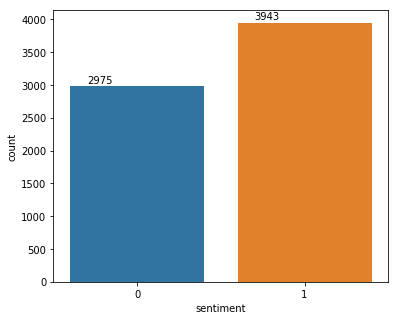

In [8]:
plt.figure(figsize=(6,5))

# Create count plot
ax = sn.countplot(x='sentiment', data=train_ds)
for p in ax.patches:
         ax.annotate(p.get_height(), (p.get_x()+0.1, p.get_height()+50))

## Text Pre-Preprocessing

### Bag-of-Words (BoW) Model
- Each sentence is treated as a bag of words and called a document.
- Collection of all documents is called corpus.

In [9]:
# Creating Count Vectors for sentiment_train Dataset
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
count_vectorizer = CountVectorizer()

# Create the dictionary from the corpus
feature_vector = count_vectorizer.fit(train_ds.text)

# Get the feature names
features = feature_vector.get_feature_names()
print("Total number of features: ", len(features))

Total number of features:  2132


In [10]:
import random
random.sample(features, 10)

['broke',
 'thought',
 'spoke',
 'clive',
 'have',
 'various',
 'guts',
 'finished',
 'it',
 'fix']

In [11]:
# convert all the documents in the dataset to count vectors 
train_ds_features = count_vectorizer.transform(train_ds.text)

In [12]:
train_ds_features.shape

(6918, 2132)

In [48]:
train_ds_features.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
train_ds_features.getnnz()

65398

In [70]:
print("Density of the matrix: ", 
      train_ds_features.getnnz() * 100 / (train_ds_features.shape[0] 
                                          * train_ds_features.shape[1]))

Density of the matrix:  0.39124024284475284


In [15]:
# Converting the matrix to a dataframe
train_ds_df = pd.DataFrame(train_ds_features.todense())
# Setting the column names to the features i.e. words
train_ds_df.columns = features

In [16]:
train_ds[0:1]

,sentiment,text
0,1,The Da Vinci Code book is just awesome.


In [17]:
 train_ds_df[['awesome']][0:1]

,awesome
0,1


#### Removing Low-frequency Words

In [18]:
# Summing up the occurrences of features column wise
features_counts = np.sum(train_ds_features.toarray(), axis = 0)
feature_counts_df = pd.DataFrame(dict(features = features, counts = features_counts))

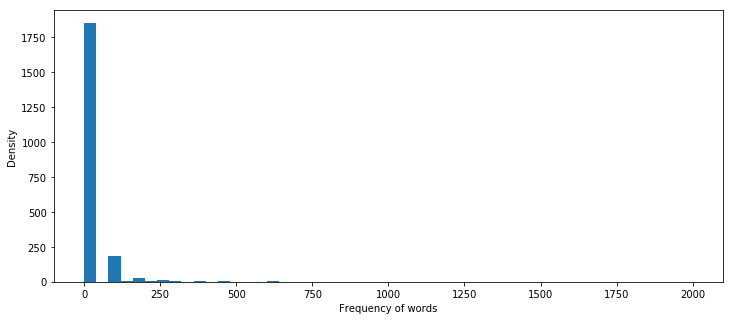

In [19]:
plt.figure(figsize=(12,5))
plt.hist(feature_counts_df.counts, bins=50, range = (0, 2000));
plt.xlabel('Frequency of words')
plt.ylabel('Density');

In [20]:
len(feature_counts_df[feature_counts_df.counts == 1])

1228

##### We can restrict the number of features by setting max_features parameters to 1000 while creating the count vectors.

In [21]:
# Initialize the CountVectorizer
count_vectorizer = CountVectorizer(max_features=1000)

# Create the dictionary from the corpus
feature_vector = count_vectorizer.fit(train_ds.text)

# Get the feature names
features = feature_vector.get_feature_names()

# Transform the document into vectors
train_ds_features = count_vectorizer.transform(train_ds.text)

# Count the frequency of the features
features_counts = np.sum(train_ds_features.toarray(), axis = 0)
feature_counts = pd.DataFrame(dict(features = features,
                                   counts = features_counts))

In [54]:
feature_counts.shape

(1000, 2)

In [22]:
feature_counts.sort_values('counts', ascending = False)[0:15]

,features,counts
866,the,3306
37,and,2154
358,harry,2093
675,potter,2093
138,code,2002
934,vinci,2001
178,da,2001
528,mountain,2000
104,brokeback,2000
488,love,1624


#### Removing Stop Words

In [56]:
from sklearn.feature_extraction import text 

my_stop_words = text.ENGLISH_STOP_WORDS

#Printing first few stop words
print("Few stop words: ", list(my_stop_words)[0:10])

Few stop words:  ['towards', 'former', 'third', 'show', 'five', 'afterwards', 'becoming', 'almost', 'together', 'us']


In [57]:
# Adding custom words to the list of stop words
my_stop_words = text.ENGLISH_STOP_WORDS.union(['harry', 'potter', 'code', 'vinci', 'brokeback', 
                                               'da', 'harry', 'mountain', 'movie', 'movies'])

In [61]:
# Setting stop words list
count_vectorizer = CountVectorizer(stop_words = my_stop_words,
                                   max_features = 1000)
feature_vector = count_vectorizer.fit(train_ds.text)

In [62]:
train_ds_features = count_vectorizer.transform(train_ds.text)
features = feature_vector.get_feature_names()
features_counts = np.sum(train_ds_features.toarray(), axis = 0)
feature_counts = pd.DataFrame(dict(features = features, counts = features_counts))

In [63]:
feature_counts.sort_values("counts", ascending = False)[0:15]

,features,counts
407,love,1624
39,awesome,1127
435,mission,1094
340,impossible,1093
389,like,974
744,sucks,602
742,sucked,600
296,hate,578
651,really,374
740,stupid,365


### Stemmer

In [71]:
from nltk.stem.snowball import PorterStemmer
stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

#Custom function for stemming and stop word removal
def stemmed_words(doc):
    ### Stemming of words
    stemmed_words = [stemmer.stem(w) for w in analyzer(doc)]
    
    ### Remove the words in stop words list
    non_stop_words = [word for word in stemmed_words if word not in my_stop_words]
    return non_stop_words

In [72]:
count_vectorizer = CountVectorizer(analyzer=stemmed_words,
                                   max_features = 1000)
feature_vector = count_vectorizer.fit(train_ds.text)
train_ds_features = count_vectorizer.transform(train_ds.text)
features = feature_vector.get_feature_names()
features_counts = np.sum(train_ds_features.toarray(), axis = 0)
feature_counts = pd.DataFrame(dict(features = features, counts = features_counts)) 

In [73]:
feature_counts.sort_values("counts", ascending = False)[0:15]

,features,counts
302,harri,2093
413,love,1883
791,suck,1484
922,wa,1176
399,like,1155
446,movi,1149
45,awesom,1130
440,mission,1094
350,imposs,1093
304,hate,701


#### Distribution of Words Across Different Sentiment

In [74]:
# Convert the document vector matrix into dataframe
train_ds_df = pd.DataFrame(train_ds_features.todense())

# Assign the features names to the column
train_ds_df.columns = features

# Assign the sentiment labels to the train_ds
train_ds_df['sentiment'] = train_ds.sentiment

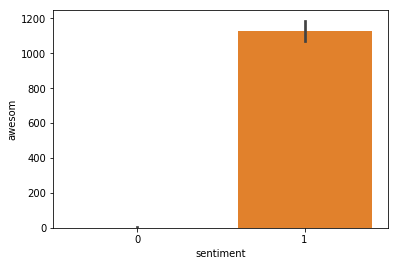

In [75]:
sn.barplot(x = 'sentiment', y = 'awesom', data = train_ds_df, estimator=sum);

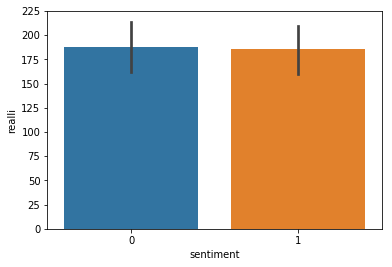

In [80]:
sn.barplot(x = 'sentiment', y = 'realli', data = train_ds_df, estimator=sum);

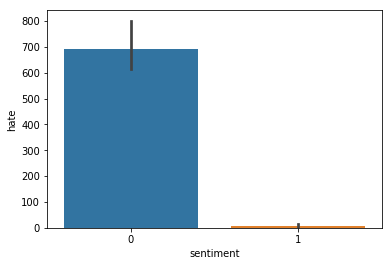

In [77]:
sn.barplot(x = 'sentiment', y = 'hate', data = train_ds_df, estimator=sum);

### NAÏVE–BAYES MODEL FOR SENTIMENT CLASSIFICATION

In [81]:
from sklearn.model_selection import train_test_split

In [82]:
train_X, test_X, train_y, test_y = train_test_split(train_ds_features, train_ds.sentiment,
                                                test_size = 0.3,
                                                random_state = 42)

In [83]:
from sklearn.naive_bayes import BernoulliNB

nb_clf = BernoulliNB()
nb_clf.fit(train_X.toarray(), train_y)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [84]:
test_ds_predicted = nb_clf.predict(test_X.toarray())

In [85]:
from sklearn import metrics 

print(metrics.classification_report(test_y, test_ds_predicted))

             precision    recall  f1-score   support

          0       0.98      0.97      0.98       873
          1       0.98      0.99      0.98      1203

avg / total       0.98      0.98      0.98      2076



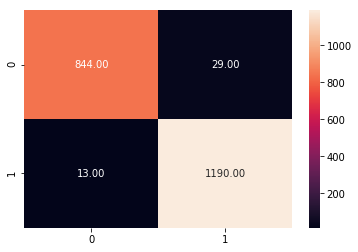

In [86]:
from sklearn import metrics

cm = metrics.confusion_matrix(test_y, test_ds_predicted) 
sn.heatmap(cm, annot=True, fmt='.2f');

### Check feature Importance using Random Forest Model 
#### Find Top features contributing to classifying a sentence as positive or Negative
#### Random Forest Hyperparameters
- No of treees (est)
- Max depth
- Max Features (sqrt)
- Crieria (Gini\Entropy)

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [88]:
rf_v1 = RandomForestClassifier()

In [89]:
rf_params = {'n_estimators': [100],
                'criterion': ['gini'],
                'max_depth': [10,15],
                'max_features': [0.1, 0.2]}

In [90]:
grid_v1 = GridSearchCV(rf_v1, 
                      param_grid = rf_params,
                      cv = 10, 
                      scoring = 'roc_auc')

In [91]:
grid_v1.fit(train_X, train_y)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100], 'criterion': ['gini'], 'max_depth': [10, 15], 'max_features': [0.1, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [92]:
grid_v1.grid_scores_

[mean: 0.99885, std: 0.00076, params: {'criterion': 'gini', 'max_depth': 10, 'max_features': 0.1, 'n_estimators': 100},
 mean: 0.99941, std: 0.00036, params: {'criterion': 'gini', 'max_depth': 10, 'max_features': 0.2, 'n_estimators': 100},
 mean: 0.99939, std: 0.00045, params: {'criterion': 'gini', 'max_depth': 15, 'max_features': 0.1, 'n_estimators': 100},
 mean: 0.99973, std: 0.00029, params: {'criterion': 'gini', 'max_depth': 15, 'max_features': 0.2, 'n_estimators': 100}]

In [93]:
grid_v1.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 0.2,
 'n_estimators': 100}

In [94]:
rf_final = grid_v1.best_estimator_

In [95]:
feature_imp_df = pd.DataFrame({'feature': features, 
                              'importance': rf_final.feature_importances_})

In [96]:
rf_final.feature_importances_.sum()

1.0

In [97]:
feature_imp_df.sort_values('importance', ascending=False)[0:20]

,feature,importance
791,suck,0.207066
413,love,0.184960
45,awesom,0.137270
304,hate,0.085814
399,like,0.036718
440,mission,0.035290
350,imposs,0.033870
784,stupid,0.033054
55,beauti,0.025061
164,depress,0.020550


### USING TF-IDF VECTORIZER

##### TfidfVectorizer is used to create both TF Vectorizer and TF-IDF Vectorizer. It takes a parameter use_idf (default True) to create TF-IDF vectors. If use_idf set to False, it will create only TF vectors and if it is set to True, it will create TF-IDF vectors.

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer=stemmed_words, max_features = 1000)
feature_vector = tfidf_vectorizer.fit(train_ds.text)
train_ds_features = tfidf_vectorizer.transform(train_ds.text)
features = feature_vector.get_feature_names()

In [100]:
from sklearn.naive_bayes import GaussianNB

train_X, test_X, train_y, test_y = train_test_split(train_ds_features, train_ds.sentiment,
                                                test_size = 0.3,
                                                random_state = 42)

In [101]:
nb_clf = GaussianNB()
nb_clf.fit(train_X.toarray(), train_y)

GaussianNB(priors=None)

In [102]:
test_ds_predicted = nb_clf.predict(test_X.toarray())

print(metrics.classification_report(test_y, test_ds_predicted))

             precision    recall  f1-score   support

          0       0.96      0.96      0.96       873
          1       0.97      0.97      0.97      1203

avg / total       0.97      0.97      0.97      2076



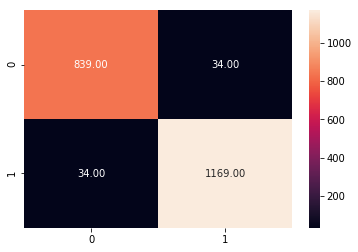

In [103]:
cm = metrics.confusion_matrix(test_y, test_ds_predicted) 
sn.heatmap(cm, annot=True, fmt='.2f');